In [1]:
from astropy.table import Table, vstack, Column
from tqdm import tqdm
from astropy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.lines import Line2D
import warnings

In [ ]:
#cs = Table.read('Control_Sample_1200.csv', format='ascii')
plt.hist(cs['mag_r']-cs['MAG_r'])
plt.show()

In [2]:
decals_raw_k_corrected = Table.read('K_corrected_decals_data.csv', format='ascii')
decals_raw = Table.read('GalfitM_DECALS_207.csv', format='ascii')
decals = decals_raw[decals_raw['type'] != 'PSF']
decals_k_corrected = decals_raw_k_corrected[decals_raw_k_corrected['type'] != 'PSF']
control_sample = Table.read('K_corrected_control_sample.csv', format='ascii')

# Convertir la tabla de astropy a un DataFrame de pandas
df = decals.to_pandas()
df2 = decals_k_corrected.to_pandas()
# Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals = Table.from_pandas(df)
decals_k_corrected = Table.from_pandas(df2)

In [3]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')
    control_sample['n_' + filtro] = pd.to_numeric(control_sample['n_' + filtro], errors='coerce')
    control_sample['RE_' +filtro] = pd.to_numeric(control_sample['RE_' + filtro], errors = 'coerce')
    control_sample['e_n_' + filtro] = pd.to_numeric(control_sample['e_n_' + filtro], errors='coerce')
    control_sample['e_RE_' +filtro] = pd.to_numeric(control_sample['e_RE_' + filtro], errors = 'coerce')
    decals_k_corrected['n_' + filtro] = pd.to_numeric(decals_k_corrected['n_' + filtro], errors='coerce')
    decals_k_corrected['RE_' +filtro] = pd.to_numeric(decals_k_corrected['RE_' + filtro], errors = 'coerce')
    decals_k_corrected['e_n_' + filtro] = pd.to_numeric(decals_k_corrected['e_n_' + filtro], errors='coerce')
    decals_k_corrected['e_RE_' +filtro] = pd.to_numeric(decals_k_corrected['e_RE_' + filtro], errors = 'coerce')

/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


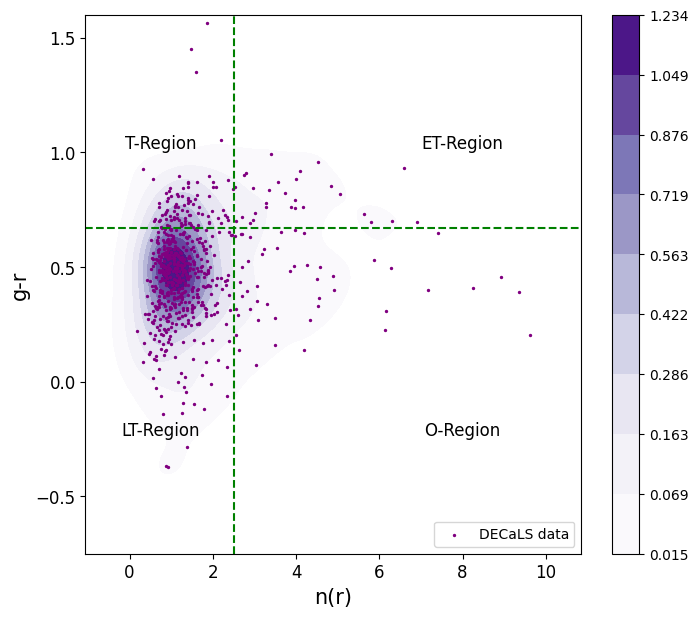

727


In [4]:
decals_no_zero = decals[decals['n_r']!=0.0]
g_r_decals = decals_no_zero['mag_g'] - decals_no_zero['mag_r']
n_r = decals_no_zero['n_r']
cs_no_zero = control_sample[control_sample['n_r'] != 0.0]
g_r_cs = cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']
n_r_cs = cs_no_zero['n_r']

plt.figure(figsize=(8, 7))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Purples', fill=True, cbar=True)

plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='DECaLS data', s=8, color='purple')

plt.ylim(-0.75, 1.6)
#plt.xlim(0, )
plt.xticks(size=12)
plt.yticks(size=12)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('g-r', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right')
plt.axhline(y=0.67, color='green', linestyle='--')

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='green', linestyle='--')

# Agregar texto en coordenadas específicas
plt.text(0.75, 1, 'T-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=12, ha='center', va='bottom', color='black')

plt.show()
print(len(decals_no_zero))

/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


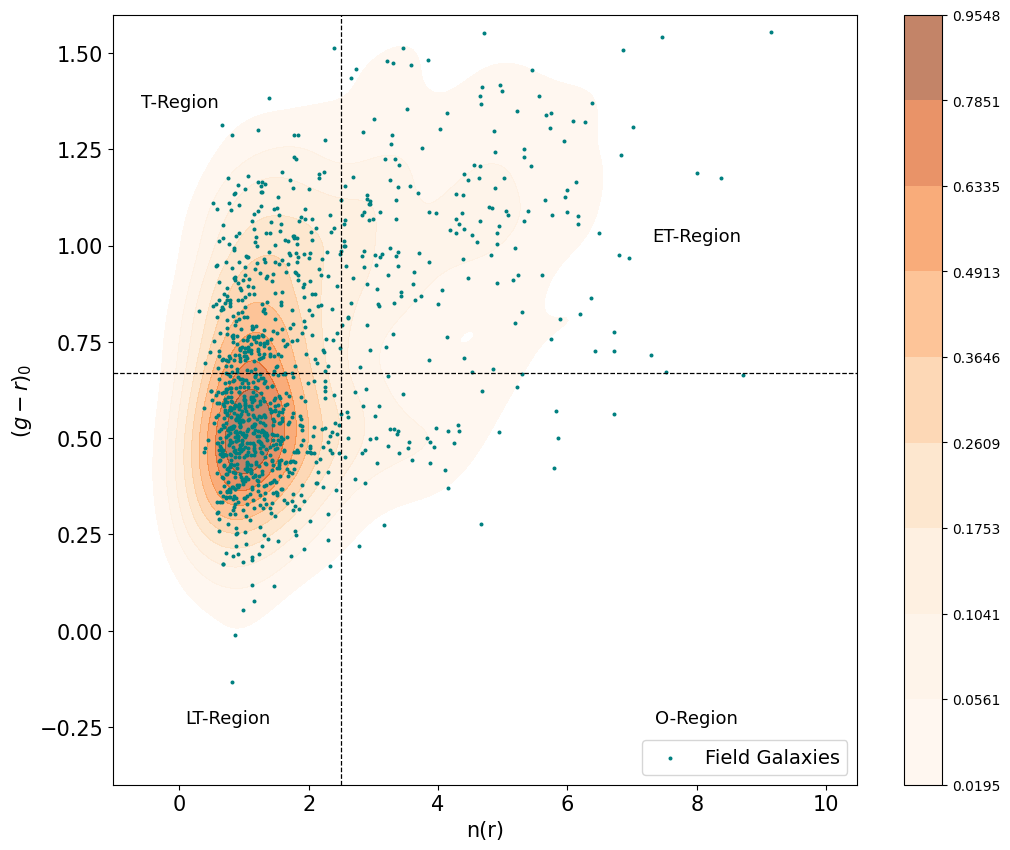

1097
0.6182621222171072


In [15]:
plt.figure(figsize=(12, 10))

sns.kdeplot(x=n_r_cs, y=g_r_cs, cmap='Oranges', alpha = 0.6, fill=True, cbar=True)

plt.scatter(cs_no_zero['n_r'], g_r_cs, marker='.', label='Field Galaxies', s=14, color='teal')

plt.ylim(-0.4, 1.6)
plt.xticks(size=15)
plt.yticks(size=15)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)

# Añadir una línea horizontal en y=50
plt.legend(loc='lower right', fontsize=14)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)

# Agregar texto en coordenadas específicas
plt.text(0, 1.35, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

plt.show()
print(len(cs_no_zero))
print(np.median(g_r_cs))

/home/seba/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


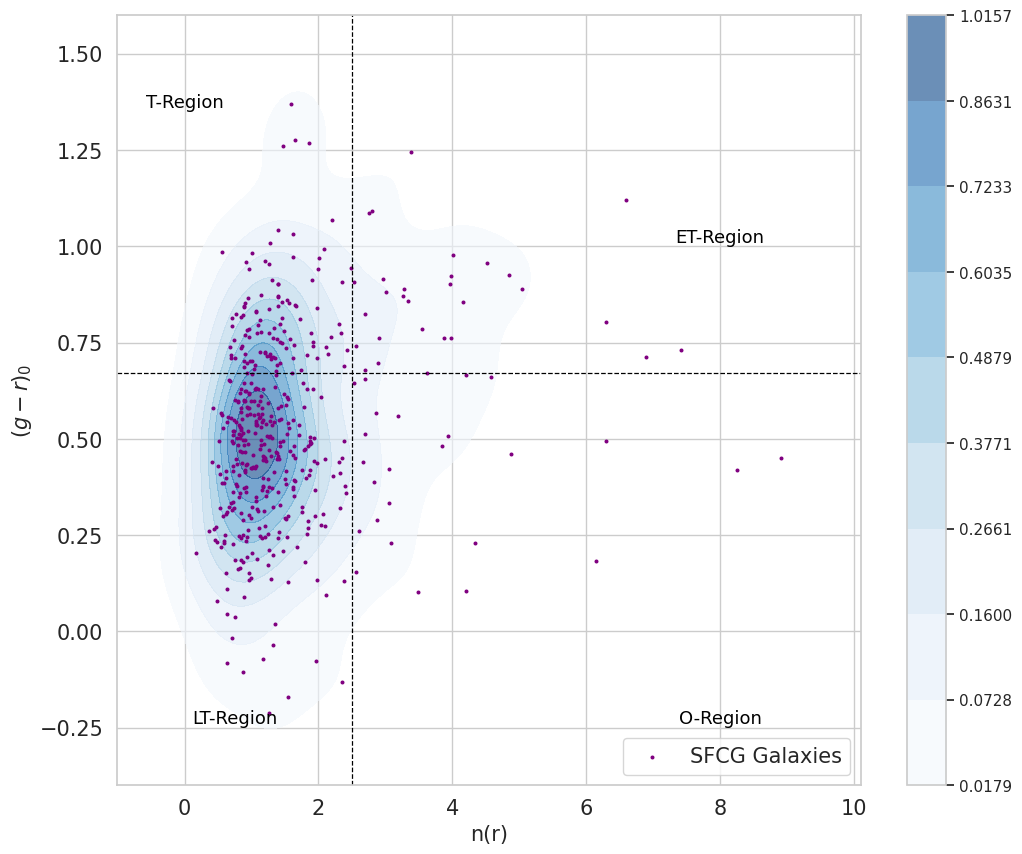

484
0.5133565192701779


In [59]:
mask = [
    isinstance(value_g, (int, float)) and isinstance(value_r, (int, float))
    for value_g, value_r in zip(decals_k_corrected['m_g_corrected'], decals_k_corrected['m_r_corrected'])
]# Aplicamos la máscara para filtrar la tabla
decals_no_zero = decals_k_corrected[mask]
decals_no_zero = decals_no_zero[decals_no_zero['n_r']!=0.0]
g_r_decals = decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']
n_r = decals_no_zero['n_r']
cs_no_zero = control_sample[control_sample['n_r'] != 0.0]
g_r_cs = cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']
n_r_cs = cs_no_zero['n_r']
median_color = np.nanmedian(g_r_decals)
plt.figure(figsize=(12, 10))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', alpha=0.6, fill=True, cbar=True)

plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='SFCG Galaxies', s=14, color='purple')

plt.ylim(-0.4, 1.6)
#plt.xlim(0, )
plt.xticks(size=15)
plt.yticks(size=15)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right', fontsize=15)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)

# Agregar texto en coordenadas específicas
plt.text(0, 1.35, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

plt.show()
print(len(decals_no_zero))

valid = []
for dato in g_r_decals:
    if isinstance(dato, (int, float)):
        valid.append(dato)
print(np.median(valid))

In [58]:
late_type_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) <= 0.67) & (decals_no_zero['n_r'] <= 2.5)]
transition_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) > 0.67) & (decals_no_zero['n_r'] <= 2.5)]
early_type_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) >= 0.67) & (decals_no_zero['n_r'] > 2.5)]
other_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) < 0.67) & (decals_no_zero['n_r'] > 2.5)]
print(len(late_type_sfcg), len(transition_sfcg), len(early_type_sfcg), len(other_sfcg), len(decals_no_zero))
#transition = transition[(transition['n_r'] != 0.0) & (transition['RE_r(kpc)'] != 0.0)]

310 109 30 25 484


In [53]:
late_type_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) < 0.67) & (cs_no_zero['n_r'] <= 2.5)]
transition_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) > 0.67) & (cs_no_zero['n_r'] <= 2.5)]
early_type_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) > 0.67) & (cs_no_zero['n_r'] > 2.5)]
other_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) < 0.67) & (cs_no_zero['n_r'] > 2.5)]
#print(len(late_type), len(transition), len(early_type), len(other))

[[ 6.32911392]
 [65.40084388]
 [22.99578059]
 [ 5.2742616 ]] [[15.77028259]
 [51.32178669]
 [27.98541477]
 [ 4.64904284]]
[[ 30]
 [310]
 [109]
 [ 25]] [[173]
 [563]
 [307]
 [ 51]]


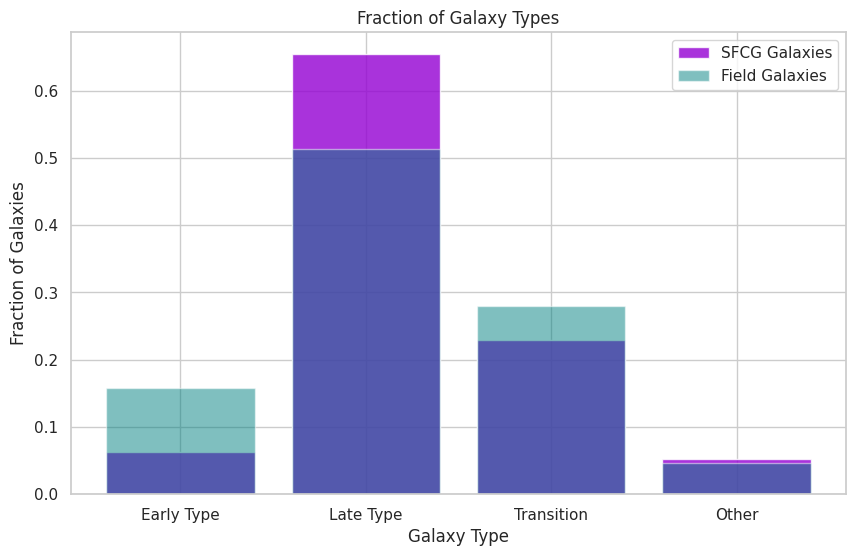

In [60]:
sns.set_theme(style='whitegrid')

tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other']

tablas_sfcg = [early_type_sfcg, late_type_sfcg, transition_sfcg, other_sfcg]
tablas_cs = [early_type_cs, late_type_cs, transition_cs, other_cs]

# Crear una lista para almacenar las fracciones para cada tabla
fractions = []
amount = []
for tabla in tablas_sfcg:
    sf_galaxies = len(tabla)
    amount.append([sf_galaxies])
    # Calcular la fracción respecto al total
    sf_fraction = sf_galaxies / 474
    
    # Añadir las fracciones a la lista
    fractions.append([sf_fraction])

fractions_cs = []
amount_cs = [] 
for tabla_cs in tablas_cs:
    field_galaxies = len(tabla_cs)
    amount_cs.append([field_galaxies])
    field_fraction = field_galaxies / len(cs_no_zero)
    
    # Añadir las fracciones a la lista
    fractions_cs.append([field_fraction])

# Convertir los resultados en un array de numpy
fractions = np.array(fractions)
fractions_cs = np.array(fractions_cs)
amount = np.array(amount)
amount_cs = np.array(amount_cs)
print(fractions*100, fractions_cs*100)
print(amount, amount_cs)
# Crear el histograma apilado
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las posiciones de los bins (uno para cada tabla)
bins = np.arange(len(tabla_names))

bar1 = ax.bar(bins, fractions[:, 0], alpha = 0.8, label='SFCG Galaxies', color='darkviolet')
bar2 = ax.bar(bins, fractions_cs[:, 0], alpha = 0.5, label='Field Galaxies', color='teal')

ax.set_xticks(bins)
ax.set_xticklabels(tabla_names)
ax.set_xlabel('Galaxy Type')
ax.set_ylabel('Fraction of Galaxies')
ax.set_title('Fraction of Galaxy Types')
ax.legend()

plt.show()

In [21]:
sfr_decals = Table.read('sfr_decals_k_corrected.csv', format='ascii')
#sfr_decals.rename_column('logSFR_NUV', 'log_SFR')
#sfr_decals.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_decals.rename_column('stellar_mass', 'stellar_mass_phot')
sfr_decals.rename_column('zmemb', 'z')
sfr_decals = sfr_decals[sfr_decals['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_decals
sfr_decals['Distance (Mpc)'] = (sfr_decals['z']*c)/H_0
sfr_decals['M_i'] = sfr_decals['m_i_corrected'] - 5*np.log10(sfr_decals['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_decals['ebv']
sfr_decals['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_decals['m_g_corrected'] - sfr_decals['m_i_corrected']) - 0.4*sfr_decals['M_i'])


type_column = Column(['SFCG Galaxy'] * len(sfr_decals), name='Nature')
sfr_decals.add_column(type_column)
mask = ~np.isnan(sfr_decals['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_decals = sfr_decals[mask]

In [22]:
sfr_cs = Table.read('sfr_cs_k_corrected.csv', format='ascii')
#sfr_cs.rename_column('logSFR_NUV', 'log_SFR')
#sfr_cs.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_cs.rename_column('stellar_mass', 'stellar_mass_phot')
sfr_cs.rename_column('zmemb', 'z')
sfr_cs = sfr_cs[sfr_cs['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_cs
sfr_cs['Distance (Mpc)'] = (sfr_cs['z']*c)/H_0
sfr_cs['M_i'] = sfr_cs['m_i_corrected'] - 5*np.log10(sfr_cs['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_cs['ebv']
sfr_cs['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_cs['m_g_corrected'] - sfr_cs['m_i_corrected']) - 0.4*sfr_cs['M_i'])


type_column = Column(['Field Galaxy'] * len(sfr_cs), name='Nature')
sfr_cs.add_column(type_column)
mask = ~np.isnan(sfr_cs['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_cs = sfr_cs[mask]

9.809295933964957 6.095017466960324 12.667545778768016


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


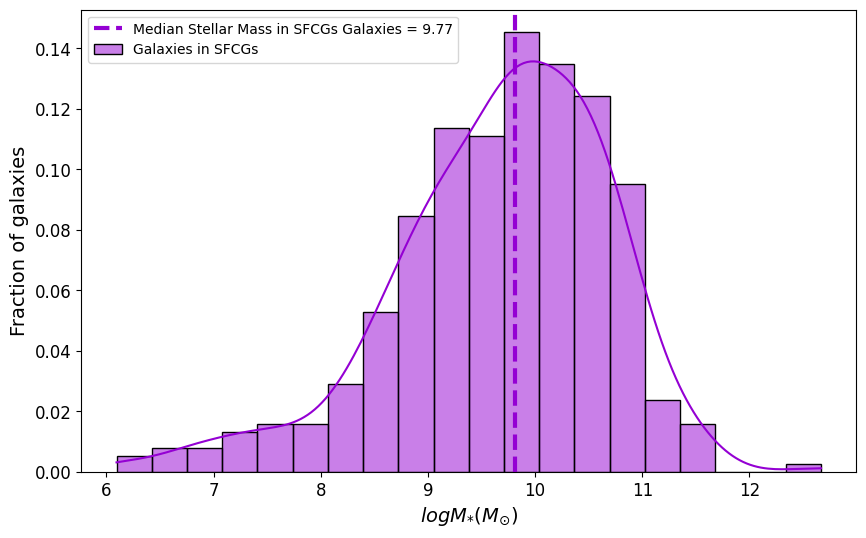

In [23]:
mass = sfr_decals['stellar_mass_phot_i']
# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass, kde=True, stat='probability', alpha=0.5, bins=20, color='darkviolet', label='Galaxies in SFCGs')

# Calcular medianas
median_x = np.median(mass)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median Stellar Mass in SFCGs Galaxies = 9.77')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, min(mass), max(mass))
plt.show()

In [24]:
type_column_cs = Column(['Field Galaxy'] * len(control_sample), name='Nature')
control_sample.add_column(type_column_cs)
control_sample['Distance (Mpc)'] = (control_sample['z']*c)/H_0
control_sample['M_i'] = control_sample['m_i_corrected'] - 5*np.log10(control_sample['Distance (Mpc)']*1000000) + 5 + 1.592*control_sample['ebv']
control_sample['stellar_mass_phot_i'] = (1.15 + 0.7*(control_sample['m_g_corrected'] - control_sample['m_i_corrected']) - 0.4*control_sample['M_i'])
control_sample

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,z,stellar_mass,error_stellar_mass,log_SFR,error_log_SFR,index,survey,band,FUV,fuv_magerr,NUV,nuv_magerr,ebv_1,m_i_corrected,m_g_corrected,m_r_corrected,m_z_corrected,FUV_corrected,NUV_corrected,Nature,Distance (Mpc),M_i,stellar_mass_phot_i
int64,int64,int64,float64,float64,str3,float64,str10,float64,str10,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,str10,float64,str10,float64,float64,float64,str9,str8,float64,float64,str8,str8,float64,float64,str10,float64,str10,float64,float64,float64,str9,str12,float64,float64,str8,str8,float64,float64,str10,float64,str10,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str12,float64,float64,float64
2,2,4345,146.037899914,5.936883936,SER,0.518974579120454,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365471,--,4345,0.03810383,90.73341,135.2012,164.73248,175.39871,1.6321088,1.1554528,1.3240439,1.287701,0.95234656,52959.43,7.7095037,7430.0376,0.034991268,353575.5,-0.09275164,544142.7,17.605581,17.172548,16.958052,16.889935,17.767561,18.341188,--,--,0.433033,0.21449661,0.28261375,0.06811714,0.0101,8.07,0.053,-1.813,0.062,1,AIS,3,19.8634,0.1513609,19.63169,0.08597316,0.0373673,16.958762436073716,17.609828071378214,17.184430474143486,16.892502838445232,19.8554745305942,19.636655586727446,Field Galaxy,44.95548961424332,-16.24448992640121,8.103541915273635
3,3,446,204.012267575,-1.608630995,SER,0.89628124496353,342.6432,0.0272,344.4836,0.0216,28.7471,0.0726,17.1758,0.0024,0.8267,0.0032,0.7809,0.0010,75.6031,0.2677,342.6432,0.0272,344.4836,0.0216,28.445,0.0478,16.7448,0.0019,0.8934,0.0019,0.7809,0.0010,75.6031,0.2677,342.6432,0.0272,344.4836,0.0216,28.1567,0.067,16.5889,0.0023,0.9569,0.0028,0.7809,0.0010,75.6031,0.2677,342.6432,0.0272,344.4836,0.0216,27.8446,0.1115,16.4979,0.0041,1.0258,0.005,0.7809,0.0010,75.6031,0.2677,322544,--,446,0.033790406,57.650288,86.54956,98.67497,111.3999,1.5149013,1.421732,1.2831888,1.2701312,1.1050656,82189.64,2.2962878,869999.6,0.044952676,1776487.1,-0.15680058,2693102.0,18.097996,17.656837,17.514482,17.382788,18.08396,18.969465,16.784136,--,0.4411583,0.14235497,0.27404976,0.1316948,0.0146,8.044,0.076,-1.269,0.103,2,MIS,1,-999.0,-999.0,19.84977,0.03946117,0.0331971,17.511085320650718,18.10583628830552,17.6732332938549,17.385759569978944,-368407.0772117822,19.8557510186381,Field Galaxy,64.98516320474776,-16.49919142284118,8.166002246494834
5,5,3209,125.743385329,24.864193396,SER,0.396124539832107,344.9315,0.0208,343.3506,0.0049,36.8885,0.0559,17.1433,0.0013,0.9171,0.0023,0.1976,0.0002,78.5132,0.0177,344.9315,0.0208,343.3506,0.0049,35.983,0.0413,16.6977,0.0013,0.9759,0.0015,0.1976,0.0002,78.5132,0.0177,344.9315,0.0208,343.3506,0.0049,35.1191,0.0629,16.5306,0.0018,1.032,0.0026,0.1

In [25]:
sfr_decals_plots = sfr_decals['Group', 'Gal', 'z', 'ra', 'dec', 'logSFR_NUV', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'm_g_corrected', 'm_r_corrected', 'm_i_corrected', 'm_z_corrected', 'e_n_r', 'e_RE_r']
control_sample_plots = sfr_cs['Group', 'Gal', 'z', 'ra', 'dec', 'logSFR_NUV', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'm_g_corrected', 'm_r_corrected', 'm_i_corrected', 'm_z_corrected', 'e_n_r', 'e_RE_r']

cg_cs = vstack([sfr_decals_plots, control_sample_plots])

In [26]:
cg_cs = cg_cs[cg_cs['logSFR_NUV'] > -10]
cg_cs['log_sSFR'] = cg_cs['logSFR_NUV'] - cg_cs['stellar_mass_phot_i']
cg_cs['RE_g'] = cg_cs['RE_g']*0.262
cg_cs['RE_r'] = cg_cs['RE_r']*0.262
cg_cs['e_RE_r'] = cg_cs['e_RE_r']*0.262
cg_cs['RE_i'] = cg_cs['RE_i']*0.262
cg_cs['RE_z'] = cg_cs['RE_z']*0.262

cg_cs['Distance (Mpc)'] = 300000*cg_cs['z']/67.4
cg_cs['RE_g(kpc)'] = (cg_cs['RE_g']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_r(kpc)'] = (cg_cs['RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['e_RE_r(kpc)'] = (cg_cs['e_RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_i(kpc)'] = (cg_cs['RE_i']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_z(kpc)'] = (cg_cs['RE_z']*cg_cs['Distance (Mpc)'])/206.265

In [27]:
cg_cs = cg_cs[cg_cs['RE_g(kpc)'] < 30]
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'SFCG Galaxy']))
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'Field Galaxy']))

4.531814984940939
4.479436985969404


/home/seba/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [29]:
print(len(cg_cs), len(cg_cs[cg_cs['Nature'] == 'SFCG Galaxy']), len(cg_cs[cg_cs['Nature'] == 'Field Galaxy']))
cg_cs = cg_cs[(~np.isinf(cg_cs['stellar_mass_phot_i'])) & (~np.isnan(cg_cs['stellar_mass_phot_i'])) & (cg_cs['n_g'] != 0.0)]
print(len(cg_cs), len(cg_cs[cg_cs['Nature'] == 'SFCG Galaxy']), len(cg_cs[cg_cs['Nature'] == 'Field Galaxy']))

1323 372 951
1323 372 951


In [ ]:
print(cg_cs[(cg_cs['stellar_mass_phot_i'] == np.inf) & (cg_cs['Nature'] == 'Field Galaxy')])

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=cg_cs['logSFR_NUV']
x=cg_cs['stellar_mass_phot_i']
sur=cg_cs['Nature']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=cg_cs,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)
# Añadir un título al gráfico
g.fig.suptitle("SFR vs Stellar Mass $(M_{\odot})$", fontsize=17)
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga con el gráfico

# Añadir una recta que pase por el punto (x, y) = (0.25, 0.25)
g.ax_joint.axline((9, 0.25), slope=0.69, color='black', linestyle='--')
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.5)
g.ax_joint.set_ylim(-2.35, 2)
g.ax_joint.text(6.5, -0.5, 'Starburst', color='black', fontsize=12, verticalalignment='bottom')
# Añadir una segunda recta continua con un label
g.ax_joint.axline((10.5, 0.5), slope=0.69, color='green', linestyle='-', label='Main sequence, Sargent+14', linewidth=2.5)
g.set_axis_labels("log $M_{*} (M_{\odot})$", "log $SFR (M_{\odot}/yr)$", fontsize=15)
g.ax_joint.tick_params(axis='both', labelsize=12)  # Cambia 12 por el tamaño de fuente deseado
# Mostrar la leyenda con el label de la recta continua
g.ax_joint.legend()

# Definir los handles y labels
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda al gráfico
g.ax_joint.legend(handles=handles, labels=labels, title="Galaxy Type", loc="upper left")

plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    
    # Añadir títulos
    g.set_axis_labels("log sSFR", f"{col}", fontsize=15)
    g.fig.suptitle(f"sSFR vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()


In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-14.2, -5)
    g.ax_joint.set_ylim(-1, 30)
    # Añadir títulos
    g.set_axis_labels("log sSFR", f"{col}", fontsize=15)
    g.fig.suptitle(f"sSFR vs Effective Radius", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['stellar_mass_phot_i']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(6, 12.5)
    g.ax_joint.set_ylim(-1, 30)
    # Añadir títulos
    g.set_axis_labels("log $M_{*} (M_{\odot})$", f"{col}", fontsize=15)
    g.fig.suptitle(f"Effective Radius vs Stellar Mass", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col_x, col_y in zip(x_columns, y_columns):
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=cg_cs[col_x], y=cg_cs[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-1.5, 11)
    g.ax_joint.set_ylim(-2.5, 30)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Effective Radius vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

## Separar las galaxias por región en el plot de g-r vs n

In [30]:
late_type = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) < 0.67) & (cg_cs['n_r'] <= 2.5)]
transition = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) > 0.67) & (cg_cs['n_r'] <= 2.5)]
early_type = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) > 0.67) & (cg_cs['n_r'] > 2.5)]
other = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) < 0.67) & (cg_cs['n_r'] > 2.5)]
print(len(late_type), len(transition), len(early_type), len(other))
transition = transition[(transition['n_r'] != 0.0) & (transition['RE_r(kpc)'] != 0.0)]

742 351 163 62


[[ 5.70652174 14.94736842]
 [65.2173913  52.84210526]
 [24.18478261 27.57894737]
 [ 4.89130435  4.63157895]]
[[ 21 142]
 [240 502]
 [ 89 262]
 [ 18  44]]


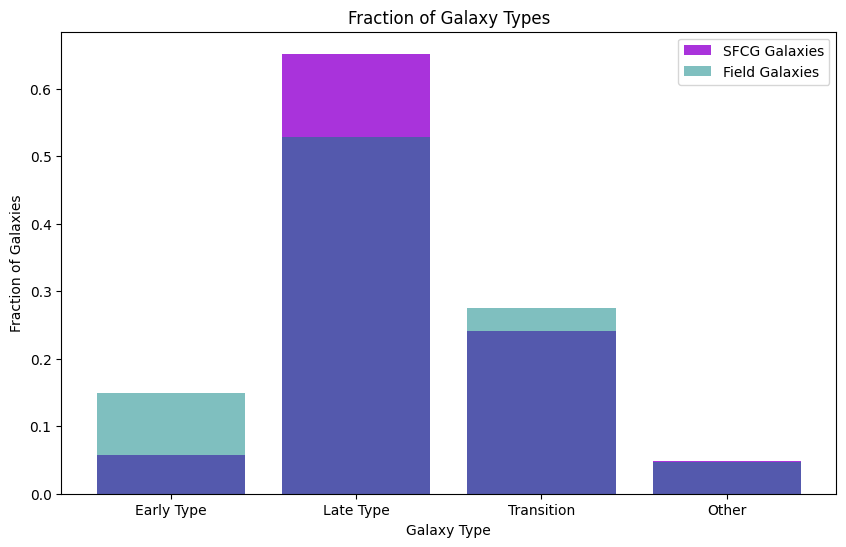

In [32]:
#sns.set_theme(style='whitegrid')

tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other']

tablas = [early_type, late_type, transition, other]

# Contar el total de galaxias por 'Nature' en todas las tablas
total_sfcg = 0
total_field = 0
for tabla in tablas:
    total_sfcg += np.sum(tabla['Nature'] == 'SFCG Galaxy')
    total_field += np.sum(tabla['Nature'] == 'Field Galaxy')

# Crear una lista para almacenar las fracciones para cada tabla
fractions = []
amount = []
for tabla in tablas:
    sf_galaxies = np.sum(tabla['Nature'] == 'SFCG Galaxy')
    field_galaxies = np.sum(tabla['Nature'] == 'Field Galaxy')
    amount.append([sf_galaxies, field_galaxies])
    # Calcular la fracción respecto al total
    sf_fraction = sf_galaxies / total_sfcg
    field_fraction = field_galaxies / total_field
    
    # Añadir las fracciones a la lista
    fractions.append([sf_fraction, field_fraction])

# Convertir los resultados en un array de numpy
fractions = np.array(fractions)
amount = np.array(amount)
print(fractions*100)
print(amount)
# Crear el histograma apilado
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las posiciones de los bins (uno para cada tabla)
bins = np.arange(len(tabla_names))

bar1 = ax.bar(bins, fractions[:, 0], alpha = 0.8, label='SFCG Galaxies', color='darkviolet')
bar2 = ax.bar(bins, fractions[:, 1], alpha = 0.5, label='Field Galaxies', color='teal')

ax.set_xticks(bins)
ax.set_xticklabels(tabla_names)
ax.set_xlabel('Galaxy Type')
ax.set_ylabel('Fraction of Galaxies')
ax.set_title('Fraction of Galaxy Types')
ax.legend()

plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=late_type,
        x=late_type[col_x], y=late_type[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 4)
    g.ax_joint.set_ylim(-2.5, 17.5)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Late Type Galaxies", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=transition,
        x=transition[col_x], y=transition[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 4)
    g.ax_joint.set_ylim(-2.5, 17.5)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Transition Galaxies", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = early_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=early_type,
        x=early_type[col_x], y=early_type[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 11)
    g.ax_joint.set_ylim(-2.5, 30)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Early Type Galaxies", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x = late_type['log_sSFR']
y = late_type['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=late_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(0, 3)
# Añadir títulos
g.set_axis_labels(f"log sSFR[$yr^{-1}$]", f"n(r)", fontsize=15)
g.fig.suptitle(f"Late Type Galaxies", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x = transition['log_sSFR']
y = transition['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=late_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(0, 3)
# Añadir títulos
g.set_axis_labels(f"log(sSFR[$yr^{-1}$])", f"n(r)", fontsize=15)
g.fig.suptitle(f"Transition Galaxies", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

In [ ]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = early_type['Nature']

# Lista de columnas que quieres graficar
x = early_type['log_sSFR']
y = early_type['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=early_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(1.5, 10)
# Añadir títulos
g.set_axis_labels(f"log(sSFR[$yr^{-1}$])", f"n(r)", fontsize=15)
g.fig.suptitle(f"Early Type Galaxies", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

In [ ]:
# Diccionario con los tipos de galaxias
galaxy_types = {'Early Type': early_type, 'Transition Galaxies': transition, 'Late Type': late_type}

# Colores para los dos tipos de galaxias
color_map = {'SFCG Galaxy': 'darkviolet', 'Field Galaxy': 'teal'}

# Figuras y ejes
fig, axs = plt.subplots(6, 6, figsize=(20, 20), gridspec_kw={'width_ratios': [6, 2, 6, 2, 6, 2], 'height_ratios': [2, 6, 2, 6, 2, 6]})

# Iterar sobre cada tipo de galaxia y cada columna de Re (g, r, z)
for i, (name, data) in enumerate(galaxy_types.items()):
    for j, re_col in enumerate(['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']):
        ax = axs[2*i-1, 2*j-2]
        ax_histx = axs[2*i-2, 2*j-2] #Panel del histograma en x
        ax_histy = axs[2*i-1, 2*j-1] #Panel del histograma en y
        

        ax.set_title(f'{name}', size=20)
        # Dividir los datos por Nature
        for nature_type, color in color_map.items():
            subset = data[data['Nature'] == nature_type]
            
            #Graficando KDE
            kde_plot = sns.kdeplot(x=subset['stellar_mass_phot_i'], y=subset[re_col], ax=ax, fill=False, color=color, alpha = 0.6, label=nature_type)
            
            # Calcular medianas
            median_x = np.median(subset['stellar_mass_phot_i'])
            median_y = np.median(subset[re_col])
            
            #Histogramas
            ax_histx.hist(subset['stellar_mass_phot_i'], bins=10, color=color, alpha=0.6, density=True)
            ax_histy.hist(subset[re_col], bins=10, color=color, alpha=0.6, orientation='horizontal', density=True)
        
            # Añadir líneas de la mediana
            ax_histx.axvline(median_x, color=color, linestyle='--', linewidth=3)
            ax_histy.axhline(median_y, color=color, linestyle='--', linewidth=3)
        
        # Personalización de ejes
        ax_histx.set_xlim(ax.get_xlim())
        ax_histy.set_ylim(ax.get_ylim())
        ax_histy.yaxis.set_label_position("left")
        ax_histy.yaxis.tick_right()
        # Etiquetas personalizadas de los ejes
        ax.set_xlabel(f'log($M_*(M_\odot)$)', size=15)
        ax.set_ylabel(f'{re_col}', size=15)
        # Cambiar el tamaño de las etiquetas de los ticks
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels, title='Galaxy Type', loc='upper left')
# Eliminar los ejes innecesarios (las filas 1, 3 y 5, columnas 2, 4 y 6)
for i in [0, 2, 4]:
    for j in [1, 3, 5]:
        axs[i, j].set_visible(False)
# Configuración global
plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)  # Reducir espacios entre subplots

plt.show()

In [ ]:
median_re_late_sfcg = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_re_late_sfcg = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_re_transition_sfcg = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_error_re_transition_sfcg = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_re_early_sfcg = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_re_early_sfcg = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])

median_re_late_cs = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_error_re_late_cs = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_re_transition_cs = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_error_re_transition_cs = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_re_early_cs = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])
median_error_re_early_cs = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])

median_n_late_sfcg = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_n_late_sfcg = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_n_transition_sfcg = np.nanmedian(transition['n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_error_n_transition_sfcg = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_n_early_sfcg = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_n_early_sfcg = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'SFCG Galaxy'])

median_n_late_cs = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'Field Galaxy'])
median_error_n_late_cs = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'Field Galaxy'])
median_n_transition_cs = np.nanmedian(transition['n_r'][transition['Nature'] == 'Field Galaxy'])
median_error_n_transition_cs = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'Field Galaxy'])
median_n_early_cs = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'Field Galaxy'])
median_error_n_early_cs = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'Field Galaxy'])

print(f'Median effective radius for late type SFCG galaxies: {median_re_late_sfcg} \u00B1 {median_error_re_late_sfcg}')
print(f'Median effective radius for late type Field galaxies: {median_re_late_cs} \u00B1 {median_error_re_late_cs}')

print(f'Median effective radius for transition SFCG galaxies: {median_re_transition_sfcg} \u00B1 {median_error_re_transition_sfcg}')
print(f'Median effective radius for transition Field galaxies: {median_re_transition_cs} \u00B1 {median_error_re_transition_cs}')

print(f'Median effective radius for early type SFCG galaxies: {median_re_early_sfcg} \u00B1 {median_error_re_early_sfcg}')
print(f'Median effective radius for early type Field galaxies: {median_re_early_cs} \u00B1 {median_error_re_early_cs}')

print(f'Median Sérsic Index for late type SFCG galaxies: {median_n_late_sfcg} \u00B1 {median_error_n_late_sfcg}')
print(f'Median Sérsic Index for late type Field galaxies: {median_n_late_cs} \u00B1 {median_error_n_late_cs}')

print(f'Median Sérsic Index for transition SFCG galaxies: {median_n_transition_sfcg} \u00B1 {median_error_n_transition_sfcg}')
print(f'Median Sérsic Index for transition Field galaxies: {median_n_transition_cs} \u00B1 {median_error_n_transition_cs}')

print(f'Median Sérsic Index for early type SFCG galaxies: {median_n_early_sfcg} \u00B1 {median_error_n_early_sfcg}')
print(f'Median Sérsic Index for early type Field galaxies: {median_n_early_cs} \u00B1 {median_error_n_early_cs}')


In [ ]:
re_late_sfcg = transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy']
re_late_cs = transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(re_late_sfcg.min(), re_late_cs.min()), 
                        max(re_late_sfcg.max(), re_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(re_late_sfcg, kde=True, stat='density', alpha=0.5, bins=20, color='darkviolet', label='Galaxies in CGs')
sns.histplot(re_late_cs, kde=True, stat='density', alpha=0.5, bins=20, color='teal', label='Galaxies in the field')

# Etiquetas y título
plt.xlabel('$Re_{r} (kpc)$')
plt.ylabel('Fraction of galaxies')
plt.title('Effective Radius')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(re_late_sfcg, re_late_cs)
print(ks_stat, p_value)

In [ ]:
mass_transition_sfcg = transition['stellar_mass_phot_i'][transition['Nature'] == 'SFCG Galaxy']
mass_transition_cs = transition['stellar_mass_phot_i'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(mass_transition_sfcg.min(), mass_transition_cs.min()), 
                        max(mass_transition_sfcg.max(), mass_transition_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass_transition_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in CGs')
sns.histplot(mass_transition_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the field')

# Calcular medianas
median_x = np.median(mass_transition_sfcg)
median_x_2 = np.median(mass_transition_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median CGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$')
plt.ylabel('Fraction of galaxies')
plt.title('Stellar Mass in the Transition Galaxies')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_transition_sfcg, mass_transition_cs)
print(ks_stat, p_value)

In [ ]:
mass_late_sfcg = late_type['stellar_mass_phot_i'][late_type['Nature'] == 'SFCG Galaxy']
mass_late_cs = late_type['stellar_mass_phot_i'][late_type['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(mass_late_sfcg.min(), mass_late_cs.min()), 
                        max(mass_late_sfcg.max(), mass_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass_late_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in CGs')
sns.histplot(mass_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the field')

# Calcular medianas
median_x = np.median(mass_late_sfcg)
median_x_2 = np.median(mass_late_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median CGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$')
plt.ylabel('Fraction of galaxies')
plt.title('Stellar Mass in the Transition Galaxies')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_late_sfcg, mass_late_cs)
print(ks_stat, p_value)

In [ ]:
sfr_sfcg = cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'SFCG Galaxy']
sfr_cs = cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'Field Galaxy']
sfr_sfcg
bin_edges = np.linspace(min(mass_late_sfcg.min(), mass_late_cs.min()), 
                        max(mass_late_sfcg.max(), mass_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(sfr_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in CGs')
sns.histplot(sfr_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the field')

# Calcular medianas
median_x = np.nanmedian(sfr_sfcg)
median_x_2 = np.nanmedian(sfr_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median CGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$')
plt.ylabel('Fraction of galaxies')
plt.title('Stellar Mass in the Transition Galaxies')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(sfr_sfcg, sfr_cs)
print(ks_stat, p_value)